Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

# Coursework 1: Spam filtering


![](spam.jpeg)

[Spam email](https://en.wikipedia.org/wiki/Email_spam) are unsolicited junk emails, typically sent in bulk.

In this assignment, we'll use a public dataset of emails, some of which are spam, to train a classifier that could be used to filter emails.

## Goals

Your (programming) task is to:
1. Implement two different loss functions and their gradients
2. Implement the Adagrad optimization algorithm


This assignment also functions as a tutorial and introduction to software that we'll be using throughout the term:
* Python programming language
* Numpy (and Scipy) for scientific and numerical computing
* Jupyter notebooks and matplotlib for interactive programming and plotting

## Look at the data

Before you start, take a look at the data. It's in the `data_train` subfolder. Each text file is a single email. The subfolders inside of `data_train` include examples of spam and "ham" (i.e. not spam) — some of the "ham" emails are easier examples than others.

## If you haven't used Jupyter notebooks before

Then, first, congratulations: If you're viewing this page in a browser, it means you've successfully installed Jupyter and launched the notebook server.

The main things to know are:
* The notebook is composed of various *cells*. You can run the selected cell by using the "run" button on the toolbar, or by pressing `<shift>+<return>`.
* You can run cells manually in any order, and that's fine when prototyping, but **be careful**. Your final notebook must run **in order, top to bottom** without errors. To test this, in the menu, go to "kernel" -> "restart and run all". This is how your code will be run by the grading system.
* This first cell includes important import statements.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Numpy

Numpy provides fast, vectorized implementations of many operations you might perform with matrices.

One thing to note: the `*` operation performs elementwise multiplication (which may broadcast across dimensions) and `@` performs matrix multiplication. For example:

In [2]:
A = np.array([[1., 2.],
              [2., 3.],
              [2., 1.]])

b = np.array([0.5, -1])

print("A:\n", A)
print("b:\n", b)
print("A * b:\n", A * b)
print("A @ b:\n", A @ b)
del A, b

A:
 [[1. 2.]
 [2. 3.]
 [2. 1.]]
b:
 [ 0.5 -1. ]
A * b:
 [[ 0.5 -2. ]
 [ 1.  -3. ]
 [ 1.  -1. ]]
A @ b:
 [-1.5 -2.   0. ]


## Feature representation

We're going to load the spam training dataset, and encode each "token" (i.e. word) of the email into a one-hot representation.

This is a little bit different than the one-hot representation we talked about in class, because the overall number of tokens is unknown. Instead, we define a fixed (maximum) number of tokens $B$, and use the python `hash` function, which maps any object to an integer, modulo $B$. Note that this means that if there are more than $B$ tokens in the dataset, then there will be a collision, i.e. multiple tokens will have the same one-hot representation. (If $B$ is sufficiently large, this won't be a problem.)

In [3]:
# tokenize the email and hashes the symbols into a vector
def extractfeaturesnaive(path, B):
    with open(path, 'r', encoding='utf-8') as femail:
        # initialize all-zeros feature vector
        v = np.zeros(B)
        email = femail.read()
        # breaks for non-ascii characters
        tokens = email.split()
        for token in tokens:
            v[hash(token) % B] = 1
    return v


def loadspamdata(extractfeatures, B=512, path="../../spam-data/"):
    '''
    INPUT:
    extractfeatures : function to extract features
    B               : dimensionality of feature space
    path            : the path of folder to be processed
    
    OUTPUT:
    X, Y
    '''
    if path[-1] != '/':
        path += '/'
    
    with open(path + 'index', 'r') as f:
        allemails = [x for x in f.read().split('\n') if ' ' in x]
    
    xs = np.zeros((len(allemails), B))
    ys = np.zeros(len(allemails))
    for i, line in enumerate(allemails):
        label, filename = line.split(' ')
        # make labels +1 for "spam" and -1 for "ham"
        ys[i] = (label == 'spam') * 2 - 1
        xs[i, :] = extractfeatures(path + filename, B)
    print('Loaded %d input emails.' % len(ys))
    return xs, ys

X,Y = loadspamdata(extractfeaturesnaive)
X.shape

Loaded 5000 input emails.


(5000, 512)

This is your training set. To evaluate your algorithm you should split it off into a validation set.

In [4]:
# Split data into training and validation
n, d = X.shape
cutoff = int(np.ceil(0.8 * n))
# indices of training samples
xTr = X[:cutoff,:]
yTr = Y[:cutoff]
# indices of testing samples
xTv = X[cutoff:,:]
yTv = Y[cutoff:]

In [5]:
print("Q: How many emails in the training are spam?\nA:", (yTr == +1).sum(), "of", yTr.shape[0])

Q: How many emails in the training are spam?
A: 1612 of 4000


<p>This should generate a training data set <code>xTr</code>, <code>yTr</code> and a validation set <code>xTv</code>, <code>yTv</code> for you. </p>

## Implement logistic regression, using Adagrad

For this assignment, our labels take values $y_i \in \{ +1, -1 \}$. 

This means we can define the logistic regression loss as

$$\mathcal{L}(\mathbf{w}) = \sum_{i=1}^N \log \big(1 + \exp( - y_i \mathbf{w}^\top \mathbf{x}_i )\big).$$

In the next cell, your assignment is to implement a function that returns
1. The loss $\mathcal{L}(\mathbf{w})$ in the equation above; and
2. Its gradient with respect to $\mathbf{w}$, i.e., $\nabla_\mathbf{w}\mathcal{L}(\mathbf{w})$, which is a vector the same size as $\mathbf{w}$.

Functions in python can return two values by returning a tuple, e.g. `return loss, grad`.

### PART 1: Logistic loss (3 points)

In [6]:
def logistic(w,xTr,yTr):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w 
    """
    n, d = xTr.shape
    # YOUR CODE HERE
    loss = 0
    grad = 0
    for i in range(len(yTr)):
        loss += np.log(1+np.exp(-yTr[i]*(xTr[i]@w)))
        grad += (-yTr[i]*xTr[i]*np.exp(-yTr[i]*(xTr[i]@w)))/(1+np.exp(-yTr[i]*(xTr[i]@w)))
    return loss, grad

Your implementation above will be run through an automatic grader, which runs test cases similar to the following, that checks to make sure the output is correct for a particular set of inputs. The following cell will raise an exception if your implementation is not correct:

In [7]:
assert np.isclose(5.2881367,
                  logistic(np.array([-1.16,  1.32]),
                           np.array([[-0.02, -1.05],
                                     [-1.32,  0.29],
                                     [-2.11, -0.60]]),
                           np.array([ 0.37, -1.06, -1.23 ]))[0], atol=1e-6)


In [8]:
# (GRADING)

In [9]:
# (GRADING)

There are additional "hidden" test cases along the lines of these, which are run by the grading code.

### Side note: finite differences

An  alternative to  deriving the gradient analytically is to estimate it numerically. This is very slow, but it is a convenient  way to check your code for correctness.  The following function  uses numerical differentiation to evaluate the correctness of ridge.  If your code is correct, the norm difference between the two should be very small (smaller than $10^{-8}$). 
Keep in mind that this only checks if the gradient corresponds to the loss, but not if the loss is correct. The function also plots an image of the gradient values (blue) and their estimates (red). If the gradients are correct, these two should be right on top of each other.

You can use this to self-test whether your gradient implementation matches your loss.

The norm ratio is 0.0000000044.


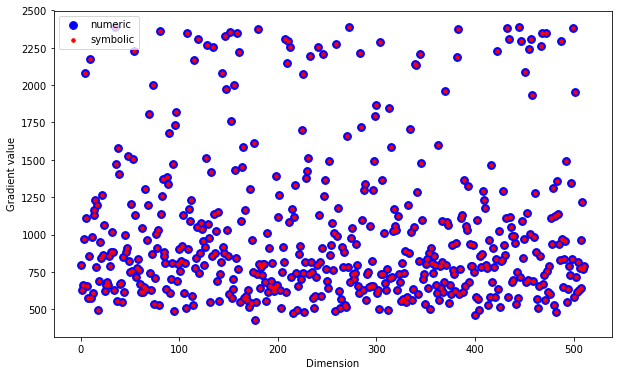

In [10]:
def numericalgradient(fun,w,e):
    # get dimensionality
    d = len(w)
    # initialize numerical derivative
    dh = np.zeros(d)
    # go through dimensions
    for i in range(d):
        # copy the weight vector
        nw = w.copy()
        # perturb dimension i
        nw[i] += e
        # compute loss
        l1, temp = fun(nw)
        # perturb dimension i again
        nw[i] -= 2*e
        # compute loss
        l2, temp = fun(nw)
        # the gradient is the slope of the loss
        dh[i] = (l1 - l2) / (2*e)
    return dh

def checkgrad(fun,w,e):
    # evaluate symbolic gradient from fun()
    loss,dy = fun(w)
    # estimate gradient numerically from fun()
    dh = numericalgradient(fun,w,e)
    
    # ii = dy.argsort()
    ii = np.array([i for i in range(len(dy))])
    
    plt.figure(figsize=(10,6))
    plt.scatter([i for i in range(len(dy))], dh[ii], c='b', marker='o', s=60)
    plt.scatter([i for i in range(len(dy))], dy[ii], c='r', marker='.', s=50)
    plt.xlabel('Dimension')
    plt.ylabel('Gradient value')
    plt.legend(["numeric","symbolic"])
    
    # return the norm of the difference scaled by the norm of the sum
    return np.linalg.norm(dh - dy) / np.linalg.norm(dh + dy)

# dimensionality of the input
_, d = xTr.shape
# evaluate loss on random vector
w = np.random.rand(d)
# the lambda function notation is an inline way to define a function with only a single argument.
ratio = checkgrad(lambda weight: logistic(weight,xTr,yTr),w,1e-05)
print("The norm ratio is %.10f." % ratio)

Now implement the function <code>adagrad</code>, which performs adaptive gradient descent. 
Make sure to include the tolerance variable to stop early if the norm of the gradient is less than the tolerance value (you can use the function `np.linalg.norm(x)`). When the norm of the gradient is tiny it means that you have arrived at a minimum.

The first parameter of <code>adagrad</code> is a function which takes a weight vector and returns loss and gradient. (Take a look at how it is used in the next cell: the first argument is `lambda weight: logistic(weight, xTr, yTr)`.)

Your Adagrad implementation should compute, for iteration $t = 1,2, \dots$ until reaching `maxiter` or reaching the tolerance:

$$g_{t,d} = (\nabla_\mathbf{w} \mathcal{L}(\mathbf{w}^t))_d$$

$$w^{t+1}_{d} = w^t_d - \frac{\alpha}{\sqrt{G_{t,ii} + \epsilon}} g_{t,i}$$

with 

$$G_{t,ii} = \sum_{\tau = 1}^t g_{\tau,i}^2$$

and where $d$ ranges across the dimensions of $\mathbf{w}$, and $\mathbf{w}^t$ is the weight at iteration $t$.

### PART 2: Adagrad (4 points)

In [11]:
def adagrad(func,w,alpha,maxiter,tol=1e-02):
    """
    INPUT:
    func    : function to minimize
              (loss, gradient = func(w))
    w       : d dimensional initial weight vector 
    alpha   : initial gradient descent stepsize (scalar)
    maxiter : maximum amount of iterations (scalar)
    tol     : if norm(gradient)<tol, it quits (scalar)
    
    OUTPUTS:
     
    w      : d dimensional final weight vector
    losses : vector containing loss at each iteration
    """
    
    eps = 1e-06

    # YOUR CODE HERE
    losses = []
    G = 0
    for t in range(maxiter):
        loss, grad = func(w)
        losses.append(loss)
        G += grad*grad
        w = w - (alpha/np.sqrt(G + eps))*grad
        if np.linalg.norm(grad) < tol:
            break
    return w, losses

In [12]:
# (GRADING)

In [13]:
# (GRADING)

In [14]:
# (GRADING)

Final train loss: 93.658192


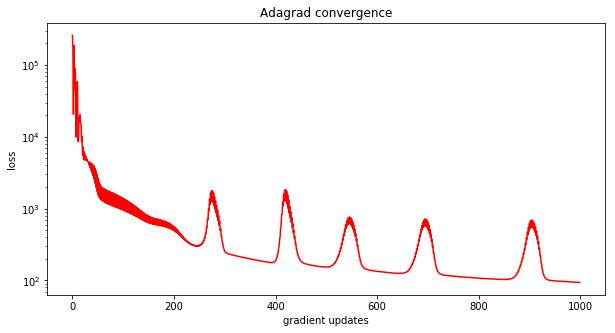

In [15]:
_, d = xTr.shape
w, losses = adagrad(lambda weight: logistic(weight, xTr, yTr), np.random.rand(d), 1.0, 1000)
#w, losses = adagrad(lambda weight: logistic(weight, xTr, yTr), np.random.rand(d), 1.0, 1000)

plt.figure(figsize=(10,5))
plt.semilogy(losses, c='r', linestyle='-')
plt.xlabel("gradient updates")
plt.ylabel("loss")
plt.title("Adagrad convergence")
print("Final train loss: %f" % losses[-1])

In [16]:
def linclassify(w,xTr):
    """ Make a +1/-1 prediction"""
    return np.sign(xTr @ w)

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

Training accuracy 99.50%
Validation accuracy 90.80%



### Exercise (ungraded, but useful!)

Take a look at the results in the previous two cells.
1. Did Adagrad run long enough so that the gradient norm was below the tolerance?
2. Try re-running this a few times. How stable are the results on re-execution?
3. Try changing the maximum number of iterations. How does this affect the gap between the training and validation accuracies?
4. Try changing the base stepsize of Adagrad. Does this affect stability, or results?

## Now let's implement a different linear classifier, a support vector machine.

The SVM objective has a hinge loss, and L2 regularization term:

$$\mathcal{L}(\mathbf{w}) = \sum_{i=1}^N \max \{ 1 - y_i \mathbf{w}^\top\mathbf{x}_i, 0 \} + \lambda \| \mathbf{w} \|_2^2.$$

Implement this loss (and its gradient) in the next cell. Again, you'll need to derive the gradient yourself!

### PART 3: Hinge loss (3 points)

In [17]:
def hinge(w,xTr,yTr,lmbda):
    """
    INPUT:
    w     : d   dimensional weight vector
    xTr   : nxd dimensional matrix (each row is an input vector)
    yTr   : n   dimensional vector (each entry is a label)
    lmbda : regression constant (scalar)
    
    OUTPUTS:
    loss     : the total loss obtained with w on xTr and yTr (scalar)
    gradient : d dimensional gradient at w
    """
    n, d = xTr.shape
    
    # YOUR CODE HERE
    loss = lmbda*np.linalg.norm(w, ord=2)**2
    grad = 2*lmbda*w
    for i in range(len(yTr)):
        loss += np.maximum(1-yTr[i]*(xTr[i]@w), 0)
        if yTr[i]*(xTr[i]@w) < 1:
            grad += - yTr[i]*xTr[i]
    return loss,grad

In [18]:
# (GRADING)

In [19]:
# (GRADING)

In [20]:
# (GRADING)

Final train loss: 346.087559
Training accuracy 98.47%
Validation accuracy 87.50%



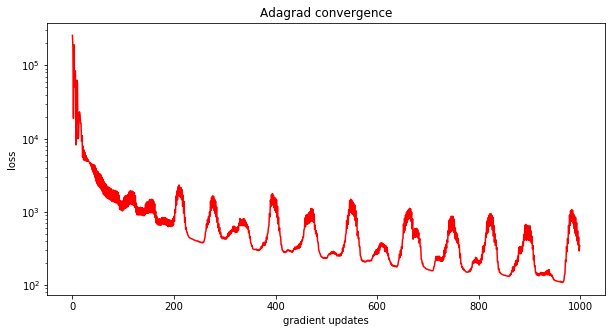

In [21]:
# set lmbda (λ) arbitrarily (but think about how else to set it!)
lmbda = 0.1

w, losses = adagrad(lambda weight: hinge(weight, xTr, yTr, lmbda), np.random.rand(d), 1, 1000)

plt.figure(figsize=(10,5))
plt.semilogy(losses, c='r', linestyle='-')
plt.xlabel("gradient updates")
plt.ylabel("loss")
plt.title("Adagrad convergence")
print("Final train loss: %f" % losses[-1])

# evaluate training accuracy
preds = linclassify(w,xTr)
trainingacc = np.mean(preds==yTr)
# evaluate testing accuracy
preds = linclassify(w,xTv)
validationacc = np.mean(preds==yTv)
print("Training accuracy %2.2f%%\nValidation accuracy %2.2f%%\n" % (trainingacc*100,validationacc*100))

## Evaluation

Q: When building a spam filter, is a false positive or a false negative more costly? These correspond to:
1. Flagging all spam, letting none through to the inbox; occasionally, real email is sent to the spam folder
2. Never mistakenly sending real email to the spam folder; but, occasionally letting spam through to the inbox

A "positive" in this setting refers to identifying a spam instance, i.e. $y = +1$.

In [22]:
def false_positive(y_hat, y):
    """
    INPUT:
    y_hat   : vector of predicted labels (+1 and -1)
    y       : vector of true labels (+1 and -1)
    
    OUTPUTS:
    fp      : number of false positives (mistakenly selected +1)
    """
    fp = np.logical_and(y_hat > 0, y < 0).sum()
    return fp

In [23]:
def false_negative(y_hat, y):
    """
    INPUT:
    y_hat   : vector of predicted labels (+1 and -1)
    y       : vector of true labels (+1 and -1)
    
    OUTPUTS:
    fp      : number of false positives (mistakenly selected +1)
    """
    fp = np.logical_and(y_hat < 0, y > 0).sum()
    return fp

In [24]:
preds = linclassify(w,xTv)
fp_val = false_positive(preds, yTv)
fn_val = false_negative(preds, yTv)

print("Validation set size:", len(yTv))
print("False positives:", fp_val)
print("False negatives:", fn_val)

Validation set size: 1000
False positives: 116
False negatives: 9


## What do these false positive and negative numbers mean, in terms of spam filter performance?

Would you use this spam filter?

By changing the prediction threshold (i.e. by adding an intercept term), it's possible to trade off between false positives and false negatives. Keep in mind there are about 1600-ish spam emails in the dataset!

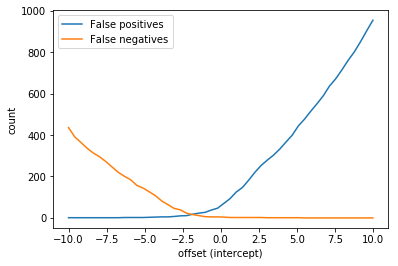

In [25]:
fp = []
fn = []
b_grid = np.linspace(-10, 10, 50)
for b in b_grid:
    preds = np.sign(xTr @ w + b)
    fp.append(false_positive(preds, yTr))
    fn.append(false_negative(preds, yTr))

plt.plot(b_grid, fp)
plt.plot(b_grid, fn)
plt.xlabel("offset (intercept)")
plt.ylabel("count")
plt.legend(['False positives', 'False negatives']);
